# DD PennyLane Analysis Notebook

## 1. Setup and Data Load

In [10]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import numpy as np

# Load datasets
df1 = pd.read_csv("results_with_jsd_2025-05-29T11:13:43.csv")
df2 = pd.read_csv("results_with_jsd_2025-05-29T11:23:25.csv")
df = pd.concat([df1, df2], ignore_index=True)
df_noisy = df[df["use_noise"] == True]


## 2. Boxplot: JSD vs Ideal by Depth

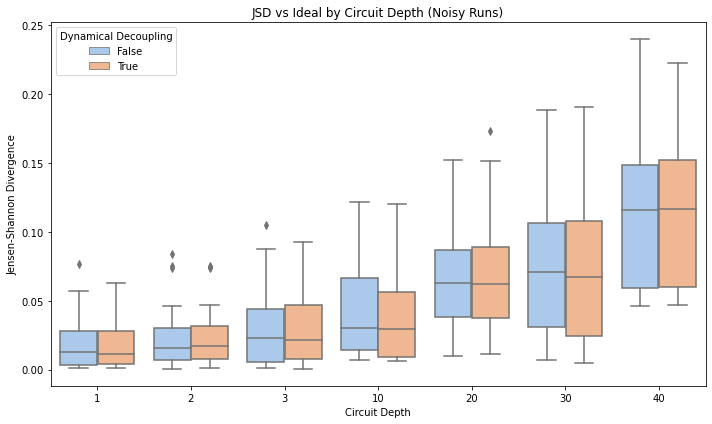

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
df1 = pd.read_csv("results_with_jsd_2025-05-29T11:13:43.csv")
df2 = pd.read_csv("results_with_jsd_2025-05-29T11:23:25.csv")
df = pd.concat([df1, df2], ignore_index=True)

# Filter to noisy runs
df_noisy = df[df["use_noise"] == True]

# Set pastel style
sns.set_palette("pastel")

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_noisy, x="circuit_depth", y="jsd_vs_ideal", hue="use_dd")
plt.title("JSD vs Ideal by Circuit Depth (Noisy Runs)")
plt.xlabel("Circuit Depth")
plt.ylabel("Jensen-Shannon Divergence")
plt.legend(title="Dynamical Decoupling")
plt.tight_layout()
# Save the figure
plt.savefig("pennylane_jsd_boxplot.png", dpi=300)
plt.show()


## 3. Boxplot: Execution Time vs Circuit Depth

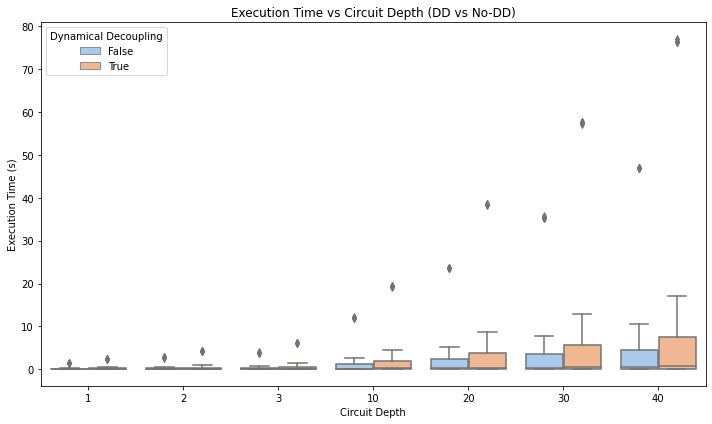

In [12]:
# Set pastel style again (in case another style is applied elsewhere)
sns.set_palette("pastel")

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_noisy, x="circuit_depth", y="execution_time", hue="use_dd")
plt.title("Execution Time vs Circuit Depth (DD vs No-DD)")
plt.xlabel("Circuit Depth")
plt.ylabel("Execution Time (s)")
plt.legend(title="Dynamical Decoupling")
plt.tight_layout()
# Save the figure
plt.savefig("pennylane_execution-time_boxplot.png", dpi=300)
plt.show()


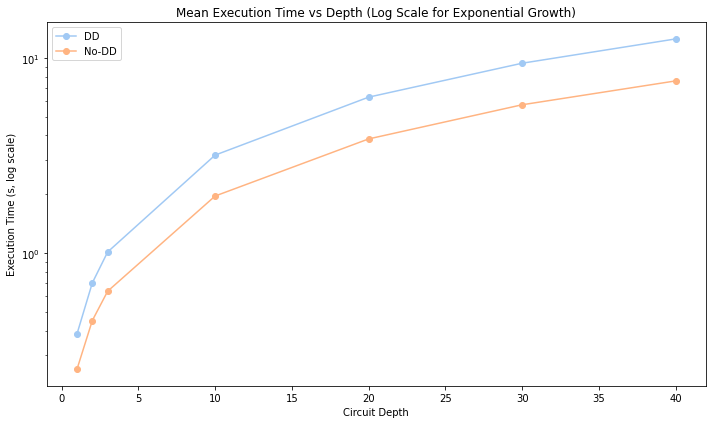

In [13]:
# Compute mean execution times
mean_exec = (
    df_noisy.groupby(["circuit_depth", "use_dd"])["execution_time"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 6))
for dd in [True, False]:
    sub = mean_exec[mean_exec["use_dd"] == dd]
    label = "DD" if dd else "No-DD"
    plt.plot(sub["circuit_depth"], sub["execution_time"], marker="o", label=label)

plt.yscale("log")  # log scale to visualize exponential growth
plt.title("Mean Execution Time vs Depth (Log Scale for Exponential Growth)")
plt.xlabel("Circuit Depth")
plt.ylabel("Execution Time (s, log scale)")
plt.legend()
plt.tight_layout()
# Save the figure
plt.savefig("pennylane_execution-time_log.png", dpi=300)
plt.show()


## 4. Summary Table by Depth

In [4]:

depths = sorted(df_noisy["circuit_depth"].unique())
summary_stats = []

for depth in depths:
    sub_df = df_noisy[df_noisy["circuit_depth"] == depth]
    grouped = sub_df.groupby("run_number")

    pairs = []
    for _, group in grouped:
        if set(group["use_dd"]) == {True, False}:
            no_dd = group[group["use_dd"] == False]["jsd_vs_ideal"].values[0]
            dd = group[group["use_dd"] == True]["jsd_vs_ideal"].values[0]
            pairs.append((no_dd, dd))

    if pairs:
        no_dd_vals, dd_vals = zip(*pairs)
        stat, p = wilcoxon(no_dd_vals, dd_vals)
        mean_no_dd = np.mean(no_dd_vals)
        mean_dd = np.mean(dd_vals)
        improvement = mean_no_dd - mean_dd
        percent = 100 * improvement / mean_no_dd if mean_no_dd != 0 else 0
        summary_stats.append((depth, mean_no_dd, mean_dd, improvement, percent, p))

summary_df = pd.DataFrame(summary_stats, columns=["depth", "mean_no_dd", "mean_dd", "mean_improvement", "percent_improvement", "p_value"])
summary_df


,depth,mean_no_dd,mean_dd,mean_improvement,percent_improvement,p_value
0,1,0.002430,0.002121,0.000309,12.732054,0.75
1,2,0.001463,0.003218,-0.001755,-119.901035,0.50
2,3,0.001784,0.001040,0.000744,41.715440,0.50
3,10,0.012076,0.007539,0.004537,37.573670,0.25
4,20,0.016091,0.013238,0.002852,17.725836,0.75
5,30,0.009724,0.008089,0.001635,16.812792,0.25
6,40,0.058332,0.060970,-0.002638,-4.522154,0.75


## 5. Summary Table by Depth and Qubit Count

In [5]:

depths = sorted(df_noisy["circuit_depth"].unique())
qubits = sorted(df_noisy["n_qubits"].unique())
dq_stats = []

for d in depths:
    for q in qubits:
        sub_df = df_noisy[(df_noisy["circuit_depth"] == d) & (df_noisy["n_qubits"] == q)]
        grouped = sub_df.groupby("run_number")

        pairs = []
        for _, group in grouped:
            if set(group["use_dd"]) == {True, False}:
                no_dd = group[group["use_dd"] == False]["jsd_vs_ideal"].values[0]
                dd = group[group["use_dd"] == True]["jsd_vs_ideal"].values[0]
                pairs.append((no_dd, dd))

        if pairs:
            no_dd_vals, dd_vals = zip(*pairs)
            stat, p = wilcoxon(no_dd_vals, dd_vals)
            mean_no_dd = np.mean(no_dd_vals)
            mean_dd = np.mean(dd_vals)
            improvement = mean_no_dd - mean_dd
            percent = 100 * improvement / mean_no_dd if mean_no_dd != 0 else 0
            dq_stats.append((d, q, mean_no_dd, mean_dd, improvement, percent, p))

dq_df = pd.DataFrame(dq_stats, columns=["depth", "n_qubits", "mean_no_dd", "mean_dd", "mean_improvement", "percent_improvement", "p_value"])
dq_df


,depth,n_qubits,mean_no_dd,mean_dd,mean_improvement,percent_improvement,p_value
0,1,3,0.002430,0.002121,0.000309,12.732054,0.75
1,1,4,0.002684,0.002985,-0.000301,-11.217041,1.00
2,1,5,0.004641,0.004221,0.000419,9.034719,1.00
3,1,6,0.012744,0.010826,0.001918,15.048447,0.50
4,1,7,0.011778,0.012637,-0.000859,-7.291866,1.00
5,1,8,0.028635,0.027224,0.001410,4.925590,0.50
6,1,9,0.026420,0.029291,-0.002871,-10.868640,0.75
7,1,10,0.062006,0.060235,0.001771,2.856640,1.00
8,2,3,0.001463,0.003218,-0.001755,-119.901035,0.50
9,2,4,0.006798,0.007733,-0.000935,-13.749906,0.25


## 6. Global Wilcoxon Test Across All Experiments

In [6]:

all_pairs = []

for _, group in df_noisy.groupby(["circuit_depth", "n_qubits", "run_number"]):
    if set(group["use_dd"]) == {True, False}:
        no_dd = group[group["use_dd"] == False]["jsd_vs_ideal"].values[0]
        dd = group[group["use_dd"] == True]["jsd_vs_ideal"].values[0]
        all_pairs.append((no_dd, dd))

all_no_dd, all_dd = zip(*all_pairs)
stat, p_value = wilcoxon(all_no_dd, all_dd)
print(f"Global Wilcoxon p-value = {p_value:.5f} (N={len(all_pairs)} pairs)")


Global Wilcoxon p-value = 0.04496 (N=168 pairs)
